# Backprop своими руками

Материалы:

* [Andrew Karpahy: yes, you should understand backprop](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b)
* [Stanford CS231n](http://cs231n.stanford.edu/)
* [Deep Learning](http://sereja.me/f/deep_learning_goodfellow.pdf) — с 204 страницы и до прозрения
* [Xavier, Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

<img width='800px' src='https://cdn-images-1.medium.com/max/1600/1*q1M7LGiDTirwU-4LcFq7_Q.png'>

Иногда сети пишут на чистом C++, причём код для обучения и инференса (реального прогона в продакшне) — отдельно. Так делают, когда нужен очень быстрый отклик и высокая производительность, но это очень трудоемко.

Большинство людей не усложняют себе жизнь и просто используют фреймворки — с ними можно просто почти декларативно описать, какие операции хотите сделать с данными, а он потом сам построит сеть и подгонит её под данные.

Ваше задание — реализовать свой небольшой фреймворк глубокого обучения на чистом `numpy`. Основное время у вас должно уйти на вывод формул для градиентов, анализ поведения самых часто используемых слоев в современных нейросетях и прочий матан. Хотя бы один раз в жизни это надо сделать, а уже потом пользоваться готовыми абстракциями.

Предполагаемый порядок выполнения:
* Поймите на высоком уровне, как работает алгоритм backpropagation
* Изучите пример с логиситической регрессией, чтобы понять, что от вас в итоге хотят
* Изучите код `Module`
* `Sequential`
* `Linear`
* `SoftMax`
* `CrossEntropy`
* Протестируйте их на логситической регрессии
* Напишите код для решения MNIST
* Дописывайте остальные слои, пока не получите на нём 97%

Оценивание (суммарно до 20 баллов):
* 5 баллов -- что-то хоть как-то обучается, MNIST на валидации >90%
* 2 балла -- MNIST на 95%, дальше по одному баллу за 96%, 97% и 98%. Это будет сделать намного сложнее, чем через PyTorch, потому что вам всё нужно писать самим: более сложные оптимизаторы, learning rate decay, думать про численную стабильность и т. д.
* По 2 балла за слои: LeakyReLU, Dropout, BatchNorm, CrossEntropy, SoftMax

Советы:
* Чтобы лучше понять, что должно в итоге получиться, изучите «игрушечный пример» и вообще эту тетрадку, а потом начните читать `hw_framework.py`, где будет более техничное описание.
* Для дебага проверяйте градиенты численно — сдвигайте параметры на какой-нибудь эпсилон и смотрите разницу. Ещё можете проверить, что на одинаковых данных они дают то же, что их эквиваленты из PyTorch (можно после каждого нового слоя добавить юнит тест через `assert`).
* Пишите код без циклов — в питоне они очень долгие; все вычисления можно делать внутри numpy.
* Ограничение на срок сдачи большое — до конца всего курса, но рекомендуется закончить примерно за месяц. Дописывайте его постепенно, разбираясь, как работает каждая функция активации.
* Обсуждайте математику и общую архитектуру фреймворка, но не шарьте друг другу код — так не интересно.

In [95]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

---

Откройте в Jupyter две тетрадки — эту и `hw_framework.ipynb`. В этой содержится train loop, а там непосредственно ваш «фреймворк», который вам ещё предстоит написать.

Архитектура фреймворка вдохновлена PyTorch. Как всегда, если придумаете какой-то более клёвый дизайн — можете использовать его.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [357]:
%run '/content/drive/MyDrive/Colab Notebooks/hw_framework.ipynb'

/usr/local/lib/python3.7/dist-packages/IPython/core/magic.py:188: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  call = lambda f, *a, **k: f(*a, **k)


CPU times: user 306 ms, sys: 20.5 ms, total: 326 ms
Wall time: 167 ms
CPU times: user 56.7 ms, sys: 820 µs, total: 57.5 ms
Wall time: 28.9 ms


Мы будем использовать самый простой вариант градиентного спуска: просто пройдемся по всем параметрам и сделаем шаги в сторону уменьшения посчитанного заранее градиента.

Есть [более продвинутые методы](http://ruder.io/optimizing-gradient-descent/), но пока что мы их использовать не будем.

In [100]:
def SGD(params, gradients, lr=1e-3):    
    for weights, gradient in zip(params, gradients):
        #print(type(lr), type(gradient))
        #print(lr, gradient)
        weights -= lr * gradient

Cоздадим обертку вокруг нашего датасета (просто numpy-евские массивы), которую будем потом использовать, чтобы итерироваться по нему.

In [101]:
def loader(X, Y, batch_size):    
    n = X.shape[0]

    # в начале каждой эпохи будем всё перемешивать
    # важно, что мы пермешиваем индексы, а не X
    indices = np.arange(n)
    np.random.shuffle(indices)
    
    for start in range(0, n, batch_size):
        # в конце нам, возможно, нужно взять неполный батч
        end = min(start + batch_size, n)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

В следующих двух секциях — игрушечные примеры регрессии и классификации на синтезированных данных. В них ничего менять не надо — они нужны, чтобы отдебажить ваши слои в `hw_framework`.

# Линейная регрессия

In [6]:
n = 1000

X = np.random.randn(n, 10)
true_w = np.random.randn(10, 1)
Y = np.dot(X, true_w).reshape(n, 1) + np.random.randn(n, 1)/5

print('best_possible_mse:', np.mean(np.power(Y-np.dot(X, true_w).reshape(n), 2)))

best_possible_mse: 42.697174459665106


### Модель

In [7]:
model = Sequential(
    Linear(10, 1),
)

criterion = MSE()

Можете тут потом тестировать остальные свои слои, когда их напишите.

### Обучение

In [ ]:
epochs = 10
batch_size = 10
learning_rate = 1e-1

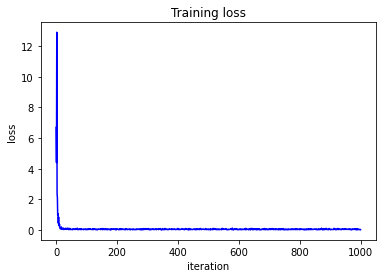

In [ ]:
history = []

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        # forward -- считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
        
        #print(y_pred, y_true)
        #print('SUM OF SQUARES:', np.mean(np.power(y_pred-y_true, 2)))
    
        # backward -- считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        #print(model.layers[0].W[0][0])
        #print(loss)
        
        history.append(loss)

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

In [ ]:
print('best_possible_mse:', np.mean(np.power(Y-np.dot(X, true_w).reshape(n), 2)))
print('final_mse:', np.mean(np.power(Y-model.forward(X), 2)))

best_possible_mse: 33.478106607464824
final_mse: 0.04658281665569653


In [ ]:
model.forward(X)[:5]

array([[-1.91044479],
       [ 5.45541478],
       [ 2.69701138],
       [ 4.69420735],
       [-4.42249654]])

In [ ]:
np.dot(X, true_w)[:5]

array([[-1.98225057],
       [ 5.37235606],
       [ 2.70150677],
       [ 4.66467427],
       [-4.36355512]])

In [ ]:
Y[:5]

array([[-2.24742449],
       [ 5.30246025],
       [ 2.50076492],
       [ 4.92669904],
       [-4.48502429]])

# Логистическая регрессия

Этот пример нужнен для теситрования классификации (`CrossEntropy` и `SoftMax`).

Возьмем в качестве датасета точки из двух гауссиан на плоскости.

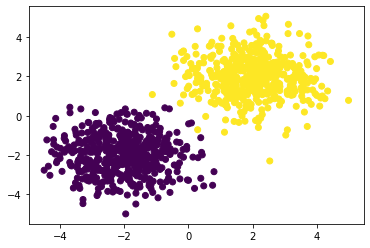

In [ ]:
n = 500

X1 = np.random.randn(n, 2) + np.array([2, 2])
X2 = np.random.randn(n, 2) + np.array([-2, -2])
X = np.vstack([X1, X2])

Y = np.concatenate([np.ones(n), np.zeros(n)])[:, None]
Y = np.hstack([Y, 1-Y])
Y = Y.astype(np.int32)

plt.scatter(X[:,0], X[:,1], c=Y[:,0])
plt.show()

Обратите внимание на `y`. Он в формате one-hot: у каждого вектора все нули, кроме одной единицы.

Выходные данные в таком формате упростят написание `CrossEntropy`.

### Модель

Логистическая регрессия — это тоже как бы маленькая нейронка: линейный слой, софтмакс, и максимизируем правдоподобие.

In [ ]:
model = Sequential(
    Linear(2, 2),
    SoftMax()
)

criterion = CrossEntropy()

### Обучение

In [ ]:
epochs = 10
batch_size = 16
learning_rate = 1e-2

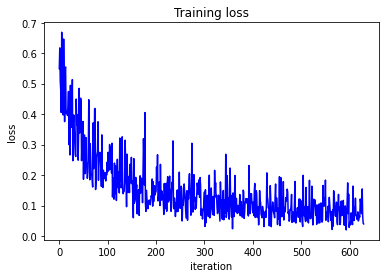

In [ ]:
history = []

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        # forward: считаем все значения до функции потерь
        y_pred = model.forward(x)
        #print(f'y_pred : {y_pred, y_pred.shape}\n y_true : {y_true, y_true.shape}\n\n')
        loss = criterion.forward(y_pred, y_true)
        
        # backward: считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        # логгируем лосс
        history.append(loss)

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

In [ ]:
np.set_printoptions(suppress=True)
print(model.forward(X))

[[0.95518835 0.04481165]
 [0.70505115 0.29494885]
 [0.96514466 0.03485534]
 ...
 [0.00573258 0.99426742]
 [0.01410429 0.98589571]
 [0.00060836 0.99939164]]


Мы тут пропустили много важных деталей: валидация, подсчет точности (кроссэнтропия не очень информативна), регуляризация. Вам всё это нужно будет реализовать потом самим.

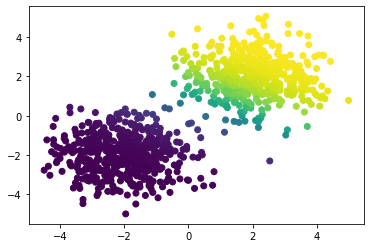

In [ ]:
plt.scatter(X[:,0], X[:,1], c=model.forward(X)[:,0])
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 10/10 [00:00<00:00, 20.58it/s]


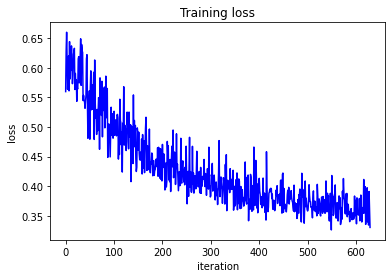

In [ ]:
import torch
from tqdm import tqdm
import torch.nn as nn

torch_model = nn.Sequential(
    nn.Linear(2, 2),
    nn.Softmax()
)
torch_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(torch_model.parameters())
torch_history = []

for e in tqdm(range(10)):
  for x, y_true in loader(X, Y, batch_size):
    optimizer.zero_grad()
    y_pred = torch_model(torch.from_numpy(x.astype(np.float32)))
    loss = torch_criterion(y_pred, torch.from_numpy(y_true.astype(np.float32)))
    loss.backward()
    torch_history.append(loss.item())
    optimizer.step()
    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(torch_history, 'b')
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


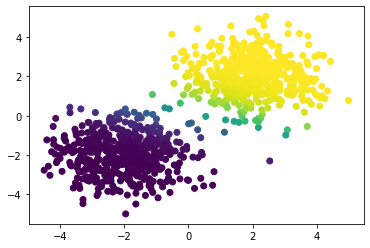

In [ ]:
plt.scatter(X[:,0], X[:,1], c=torch_model.forward(torch.from_numpy(X.astype(np.float32))).detach().numpy()[:,0])
plt.show()

# Теперь сами

In [167]:
import os
from tqdm import tqdm
from sklearn.datasets import fetch_openml
# эти библиотеки нужны только для того, чтобы скачать MNISt

if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r', allow_pickle=True) as data:
        X = data['X']
        y = data['y']
else:
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
    np.savez('mnist.npz', X=X, y=y)

In [168]:
X /= 255

Переведите лейблы в one-hot.

In [169]:
y = y.astype(np.int32)
b = np.zeros((y.size, y.max()+1))
b[np.arange(y.size),y] = 1
y = b.copy()
del(b)
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Разделите датасет на train и validation.

In [170]:
train_size = int(X.shape[0] * 0.67)
p = np.random.permutation(len(X))
X, y = X[p], y[p]

In [171]:
X_train, y_train, X_test, y_test = X[:train_size], y[:train_size], X[train_size:], y[train_size:]

Теперь напишите модель и train loop. Можете начать с адаптации предыдущего примера.

Дальше начинается творческая часть и настоящий Deep Learning:
* поиграйтесь с архитектурами;
* поиграйтесь с learning rate и batch_size;
* сделайте learning rate decay;
* сделайте data augmentation.

Have fun. Дедлайн — не две недели, а до конца курса.

In [ ]:
class Adam():
    def __init__(self, lr=1e-3, beta_1=0.9, beta_2=0.999):
        self.lr =lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2

        self.t = 0
        self.m, self.v = None, None

    def __call__(self, params, gradients):
        self.t += 1
        if self.m is None:
            self.m, self.v = np.zeros(gradients.shape), np.zeros(gradients.shape)

        self.m = self.beta_1 * self.m + (1 - self.beta_1) * gradients

        self.v = self.beta_2 * self.v + (1 - self.beta_2) * np.power(gradients, 2)

        m_hat = self.m / (1 - np.power(self.beta_1, self.t))
        v_hat = self.v / (1 - np.power(self.beta_2, self.t))
        
        params = params - self.lr * m_hat / (np.sqrt(v_hat) + 1e-8)
        
        return params

class Nadam():
    def __init__(self, lr=1e-3, beta_1=0.9, beta_2=0.999):
        self.lr =lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2

        self.t = 0
        self.m, self.v = None, None

    def __call__(self, params, gradients):
        self.t += 1
        if self.m is None:
            self.m, self.v = np.zeros(gradients.shape), np.zeros(gradients.shape)

        self.m = self.beta_1 * self.m + (1 - self.beta_1) * gradients

        self.v = self.beta_2 * self.v + (1 - self.beta_2) * np.power(gradients, 2)

        m_hat = self.m / (1 - np.power(self.beta_1, self.t))
        v_hat = self.v / (1 - np.power(self.beta_2, self.t))
        
        params = params - self.lr / (np.sqrt(v_hat) + 1e-8) * (self.beta_1 * m_hat + (1 - self.beta_1) * gradients / (1 - self.beta_1**self.t))

        return params


In [385]:
model = Sequential(
    Linear(28 * 28, 500),
    BatchNorm(500),
    ReLU(),

    Linear(500, 300),
    BatchNorm(300),
    ReLU(),

    Linear(300, 100),
    ReLU(),

    Linear(100, 10),
    SoftMax()
)

In [386]:
epochs = 100
batch_size = 128
learning_rate = 1e-3
optimizer = Nadam()
criterion = CrossEntropy()

In [387]:
def accuracy(model, val_data, val_labels):
    model.eval()
    pred = model.forward(val_data)
    return np.mean(np.argmax(pred, axis=1) == np.argwhere(y_test == 1)[:, 1])

In [388]:
history = []
best_score = 0

for e in range(epochs):
    epoch_loss = 0
    model.train()
    for x, y_true in loader(X_train, y_train, batch_size):

        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)

        model_parameters = model.parameters()
        model.set_parameters(optimizer(model_parameters, model.grad_parameters()))
        history.append(loss)
        
        history.append(loss)
        epoch_loss += loss
    epoch_val_loss = accuracy(model, X_test, y_test)
    if (epoch_val_loss > best_score):
        best_score = epoch_val_loss
        best_params = model.parameters()
    print('Epoch: {} | Training loss: {:.3f} | Validation loss: {:.3f}\n'.format(e, epoch_loss, epoch_val_loss))


Epoch: 0 | Training loss: 144.781 | Validation loss: 0.944

Epoch: 1 | Training loss: 52.895 | Validation loss: 0.955

Epoch: 2 | Training loss: 39.543 | Validation loss: 0.964

Epoch: 3 | Training loss: 31.285 | Validation loss: 0.970

Epoch: 4 | Training loss: 27.347 | Validation loss: 0.968

Epoch: 5 | Training loss: 22.705 | Validation loss: 0.970

Epoch: 6 | Training loss: 21.160 | Validation loss: 0.970

Epoch: 7 | Training loss: 19.135 | Validation loss: 0.971

Epoch: 8 | Training loss: 17.908 | Validation loss: 0.971

Epoch: 9 | Training loss: 16.413 | Validation loss: 0.973

Epoch: 10 | Training loss: 15.310 | Validation loss: 0.975

Epoch: 11 | Training loss: 14.636 | Validation loss: 0.976

Epoch: 12 | Training loss: 13.203 | Validation loss: 0.978

Epoch: 13 | Training loss: 13.900 | Validation loss: 0.976

Epoch: 14 | Training loss: 12.505 | Validation loss: 0.977

Epoch: 15 | Training loss: 12.142 | Validation loss: 0.975

Epoch: 16 | Training loss: 11.875 | Validation lo

# Nadam test


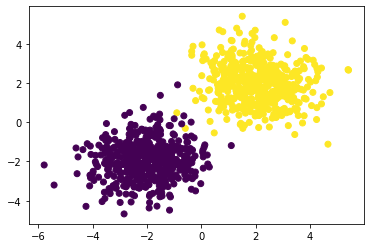

In [163]:
n = 500

X1 = np.random.randn(n, 2) + np.array([2, 2])
X2 = np.random.randn(n, 2) + np.array([-2, -2])
X = np.vstack([X1, X2])

Y = np.concatenate([np.ones(n), np.zeros(n)])[:, None]
Y = np.hstack([Y, 1-Y])
Y = Y.astype(np.int32)

plt.scatter(X[:,0], X[:,1], c=Y[:,0])
plt.show()

In [164]:
model = Sequential(
    Linear(2, 2),
    ReLU(),
    Linear(2 , 4),
    BatchNorm(4),
    ReLU(),
    Linear(4, 2),
    SoftMax()
)


In [165]:
optimizer = Nadam()
epoch = 100
criterion = CrossEntropy()
batch_size = 16

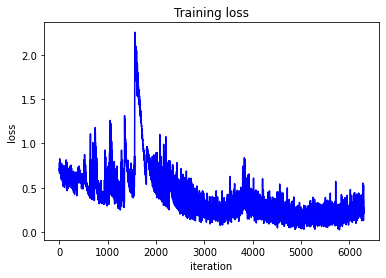

In [166]:
history = []
for e in range(epoch):
    for x, y in loader(X, Y, batch_size):
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y)
        grad = criterion.backward(y_pred, y)

        model.backward(x, grad)
        model_parameters = model.parameters()
        model.set_parameters(optimizer(model_parameters, model.grad_parameters()))
        history.append(loss)

plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

        